# TDLog : Machine Learning 

# Preparations

In [42]:
# Some imports
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import copy
import librosa
import librosa.display
import librosa.feature
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp

In [2]:
#To have access to drive files
try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  FOLDERNAME = 'TDLog'
  %cd /content/gdrive/My\ Drive/$FOLDERNAME
except ImportError:
  pass

Mounted at /content/gdrive
/content/gdrive/My Drive/TDLog


In [180]:
# Corresponding dictionnary between genre and number
label_to_int = {'blues' : 0, 'classical' : 1, 'country' : 2, 'disco' : 3, 'hiphop' : 4,
          'jazz' : 5, 'metal' : 6, 'pop' : 7, 'reggae' : 8, 'rock' : 9}
int_to_label = {0 : 'blues', 1 : 'classical', 2 : 'country', 3 : 'disco', 4 : 'hiphop',
                5 : 'jazz', 6 : 'metal', 7 : 'pop', 8 : 'reggae', 9 : 'rock'}

# Loading database 
df = pd.read_csv('Dataset/Data/features_3_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,0.081851,0.000558,-0.000078,0.008354,-0.000068,0.005535,129.199219,-118.627914,2440.286621,125.083626,260.956909,-23.443724,364.081726,41.321484,181.694855,-5.976108,152.963135,20.115141,75.652298,-16.045410,40.227104,17.855198,84.320282,-14.633434,83.437233,10.270527,97.001335,-9.708279,66.669891,10.183875,45.103611,-4.681614,34.169498,8.417439,48.269444,-7.233477,42.770947,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,0.087173,0.001030,-0.000099,0.004950,-0.000103,0.004854,123.046875,-125.590706,2038.344238,122.421227,216.774185,-20.718019,231.979767,50.128387,142.700409,-11.333302,139.243118,21.385401,77.817947,-15.960796,97.364029,19.454103,57.948093,-12.465918,68.271523,17.898169,56.222176,-11.732554,54.373909,8.145000,40.662876,-7.717751,30.808521,8.397150,48.784225,-8.300493,68.584824,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,0.071383,0.000425,-0.000066,0.012476,0.000065,0.004357,123.046875,-132.441940,3798.532227,115.085175,257.321289,-14.811666,192.448074,50.189293,144.166031,-0.680819,128.376892,24.650375,66.371170,-13.506104,89.319336,15.643386,55.253967,-13.216637,120.308784,10.406025,35.757862,-7.991465,47.911613,11.853963,36.569931,-4.677677,40.725075,6.571110,30.686846,-2.424750,50.313499,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,0.069426,0.000304,-0.000014,0.008318,0.000018,0.005927,123.046875,-118.231087,2508.781006,132.116501,332.650574,-18.758335,109.357529,39.769306,184.693344,-13.260426,144.398224,20.468134,122.516464,-14.563448,68.937332,18.745104,74.748886,-13.755463,73.868576,12.993759,41.549564,-12.648887,58.540478,10.389314,39.102024,-4.362739,60.714748,9.156193,40.411537,-9.889441,44.666325,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,0.070095,0.000289,0.000041,0.009634,-0.000106,0.005833,123.046875,-105.968376,2118.919922,134.643646,219.562622,-19.961748,171.878754,40.171753,103.120712,-14.271939,102.651230,18.734617,79.070000,-15.619381,48.510284,19.207966,53.642956,-18.274683,95.300995,14.316693,58.821163,-5.792194,55.030254,17.045437,43.229939,-5.681399,46.515259,5.705521,24.956211,-7.986080,39.816933,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [31]:
#-----Creating Dataset-----

# Changing labels into interger
if (type(df.label[0])==str):
  df.label = [label_to_int[lab] for lab in df.label]
#Shuffling data
df_random = df.sample(frac=1, ignore_index=True)
df_random

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,jazz.00061.2.wav,66149,0.367818,0.082524,0.235920,0.001120,2518.533457,1.653851e+05,2671.039484,72698.456258,5579.170110,1.015268e+06,0.104522,0.000767,-0.000199,0.039523,-2.166925e-03,5.607250e-03,89.102909,-8.808577,698.961426,82.680573,175.083786,-0.184481,194.165894,25.538958,58.323421,4.867254,36.910778,6.351689,25.773302,-0.992517,28.430511,8.504283,22.894434,-2.033928,17.774672,3.131293,23.371048,-2.884342,26.220068,4.677420,28.587948,0.787284,18.990080,0.134638,26.340036,-3.270869,28.505819,-0.950791,45.166840,-8.323819,34.400269,-3.915153,29.638000,-1.914387,30.537119,5.641682,48.974663,5
1,disco.00007.7.wav,66149,0.445592,0.082867,0.153346,0.004998,3124.454040,4.051102e+05,2673.668125,114045.732823,5974.718487,1.392858e+06,0.147585,0.002611,-0.000017,0.008449,5.985289e-07,1.205807e-02,129.199219,-61.515190,1777.896973,51.064491,672.851746,-9.660537,225.241318,35.654972,315.094696,2.911983,194.534576,17.392176,130.592743,9.364663,76.375694,3.416361,84.126038,-0.412420,61.625656,1.231472,59.397728,-0.423774,63.827744,1.845707,57.019917,0.036159,57.603817,-0.010433,33.470829,-2.748772,39.092800,-5.144092,42.942009,-1.942692,67.946869,-1.139261,63.717625,3.236939,66.683517,7.697007,64.819969,3
2,jazz.00082.2.wav,66149,0.428497,0.081931,0.040640,0.000158,4745.426447,7.600667e+05,3630.084939,41839.525181,9271.451886,5.454832e+05,0.252794,0.010147,-0.000335,0.000906,-6.916164e-04,3.788823e-04,83.354335,-171.848892,2793.159180,33.387913,347.890076,34.135284,164.171722,8.433012,31.378641,15.054230,73.147217,8.546206,38.426540,7.563496,46.471268,0.625954,29.513132,0.715497,34.994442,-3.042063,28.251089,-0.442057,31.845098,2.068299,40.612595,-3.305618,28.826656,-5.707869,40.471031,-2.361901,38.581909,-3.771770,24.640755,-3.577676,31.581381,-0.457675,36.465923,-3.194526,18.469130,-1.758591,18.102011,5
3,country.00092.9.wav,66149,0.401462,0.081829,0.151787,0.001081,2536.515617,2.534188e+05,2319.482624,78642.210190,5209.875676,7.818289e+05,0.138443,0.002132,-0.000018,0.008717,-1.277278e-04,7.196357e-03,161.499023,-66.383232,1100.347168,86.846779,265.888580,-16.317539,229.205887,66.770325,201.359940,-15.529966,78.051208,25.647951,76.918945,-20.387897,86.117561,11.219814,80.165726,-14.831967,73.902550,14.848966,72.253967,-11.945708,48.132362,9.716308,52.746651,-12.138391,47.055965,4.666826,35.707996,-5.763009,48.461838,4.550022,30.777504,-11.424688,29.831234,4.924264,34.548218,-1.514143,32.079353,1.696709,27.351269,2
4,pop.00019.3.wav,66149,0.325488,0.098960,0.181421,0.006748,2798.498877,1.555761e+06,2744.251787,238049.692407,5628.116737,4.814050e+06,0.129507,0.009610,0.000104,0.014283,-2.007774e-05,1.452855e-02,92.285156,-83.972267,4951.821289,78.046013,1501.498779,5.262437,368.038300,8.926581,210.578033,4.298063,259.539429,10.910584,239.263992,8.111615,265.688049,-10.471462,152.851624,4.839849,122.944878,-0.681833,122.559601,-8.171976,107.006882,2.735464,82.881279,-5.864569,81.586586,-9.920966,81.306252,-4.476614,97.909210,-6.760180,57.009396,0.714231,79.655190,5.664809,201.778610,10.483650,214.238937,7.216951,130.841888,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [32]:
# Removing useless columns
df_random = df_random.drop(['filename','length'], axis=1)
df_random

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.367818,0.082524,0.235920,0.001120,2518.533457,1.653851e+05,2671.039484,72698.456258,5579.170110,1.015268e+06,0.104522,0.000767,-0.000199,0.039523,-2.166925e-03,5.607250e-03,89.102909,-8.808577,698.961426,82.680573,175.083786,-0.184481,194.165894,25.538958,58.323421,4.867254,36.910778,6.351689,25.773302,-0.992517,28.430511,8.504283,22.894434,-2.033928,17.774672,3.131293,23.371048,-2.884342,26.220068,4.677420,28.587948,0.787284,18.990080,0.134638,26.340036,-3.270869,28.505819,-0.950791,45.166840,-8.323819,34.400269,-3.915153,29.638000,-1.914387,30.537119,5.641682,48.974663,5
1,0.445592,0.082867,0.153346,0.004998,3124.454040,4.051102e+05,2673.668125,114045.732823,5974.718487,1.392858e+06,0.147585,0.002611,-0.000017,0.008449,5.985289e-07,1.205807e-02,129.199219,-61.515190,1777.896973,51.064491,672.851746,-9.660537,225.241318,35.654972,315.094696,2.911983,194.534576,17.392176,130.592743,9.364663,76.375694,3.416361,84.126038,-0.412420,61.625656,1.231472,59.397728,-0.423774,63.827744,1.845707,57.019917,0.036159,57.603817,-0.010433,33.470829,-2.748772,39.092800,-5.144092,42.942009,-1.942692,67.946869,-1.139261,63.717625,3.236939,66.683517,7.697007,64.819969,3
2,0.428497,0.081931,0.040640,0.000158,4745.426447,7.600667e+05,3630.084939,41839.525181,9271.451886,5.454832e+05,0.252794,0.010147,-0.000335,0.000906,-6.916164e-04,3.788823e-04,83.354335,-171.848892,2793.159180,33.387913,347.890076,34.135284,164.171722,8.433012,31.378641,15.054230,73.147217,8.546206,38.426540,7.563496,46.471268,0.625954,29.513132,0.715497,34.994442,-3.042063,28.251089,-0.442057,31.845098,2.068299,40.612595,-3.305618,28.826656,-5.707869,40.471031,-2.361901,38.581909,-3.771770,24.640755,-3.577676,31.581381,-0.457675,36.465923,-3.194526,18.469130,-1.758591,18.102011,5
3,0.401462,0.081829,0.151787,0.001081,2536.515617,2.534188e+05,2319.482624,78642.210190,5209.875676,7.818289e+05,0.138443,0.002132,-0.000018,0.008717,-1.277278e-04,7.196357e-03,161.499023,-66.383232,1100.347168,86.846779,265.888580,-16.317539,229.205887,66.770325,201.359940,-15.529966,78.051208,25.647951,76.918945,-20.387897,86.117561,11.219814,80.165726,-14.831967,73.902550,14.848966,72.253967,-11.945708,48.132362,9.716308,52.746651,-12.138391,47.055965,4.666826,35.707996,-5.763009,48.461838,4.550022,30.777504,-11.424688,29.831234,4.924264,34.548218,-1.514143,32.079353,1.696709,27.351269,2
4,0.325488,0.098960,0.181421,0.006748,2798.498877,1.555761e+06,2744.251787,238049.692407,5628.116737,4.814050e+06,0.129507,0.009610,0.000104,0.014283,-2.007774e-05,1.452855e-02,92.285156,-83.972267,4951.821289,78.046013,1501.498779,5.262437,368.038300,8.926581,210.578033,4.298063,259.539429,10.910584,239.263992,8.111615,265.688049,-10.471462,152.851624,4.839849,122.944878,-0.681833,122.559601,-8.171976,107.006882,2.735464,82.881279,-5.864569,81.586586,-9.920966,81.306252,-4.476614,97.909210,-6.760180,57.009396,0.714231,79.655190,5.664809,201.778610,10.483650,214.238937,7.216951,130.841888,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,0.241773,0.085091,0.009520,0.000004,1104.377159,2.154143e+03,1404.939772,6020.5

In [34]:
df_y = df_random.pop('label')
df_X = df_random

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, stratify=df_test_valid_y)


In [36]:
# Scaling 
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [35]:
#Model
import tensorflow as tf
print("TF version:-", tf.__version__)
import keras as k

TF version:- 2.7.0


In [120]:
X_train

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.425055,0.241421,1.298977,-0.025828,0.577370,0.000944,0.935008,-0.062179,0.653238,0.449153,0.297893,-0.177092,0.225024,0.915115,0.420864,0.647411,-0.523540,1.288581,-0.889176,-0.407584,-0.123884,0.411291,-0.625381,-1.354828,-0.075485,0.475557,-0.305385,-0.986187,-0.506722,1.180023,0.279791,-0.407252,-0.582365,1.943465,-0.480468,-0.194410,-0.774746,-0.042675,-0.601488,-0.774079,-0.598734,0.164818,-0.882046,0.117963,-0.368032,0.662098,-0.598761,-1.052601,-0.547509,0.344714,-0.518664,-0.794188,-0.418862,-0.225657,-0.140833,-0.669247,-0.767072
1,0.729844,0.565618,0.948815,1.489187,2.669087,1.000621,2.217127,-0.592442,2.567119,-0.590554,3.086882,1.425721,-1.514659,0.104305,-2.904129,1.841392,0.132096,1.174192,-0.294662,-1.573361,-0.467006,1.140567,-0.302377,-2.040255,-0.444684,1.112766,-0.578162,-0.675660,-0.382258,1.655560,-0.475906,-0.574524,0.292437,1.373230,0.428108,-0.764123,-0.335625,0.348829,-0.477754,-0.179152,0.017498,1.716477,0.354458,0.694977,1.984076,0.179882,0.892819,0.633329,0.284921,0.376878,0.646495,-0.192696,0.420100,0.764462,1.238420,0.870498,0.240915
2,0.235276,0.553744,0.906732,0.538658,0.082677,-0.071349,0.078185,-0.384067,0.156522,-0.222926,-0.119207,0.056407,0.212466,0.744667,0.405760,0.451386,0.569187,0.762270,-0.234882,-0.113386,-0.052671,-0.137995,-0.726483,0.946095,-0.670497,-0.654235,-0.531395,0.619484,-0.602079,-0.804789,-0.410345,0.582789,-0.496644,-0.941163,0.086095,0.845143,-0.488647,-1.025334,-0.438805,0.490588,-0.371005,-0.734664,-0.105693,0.580709,-0.370828,-1.245534,-0.827118,0.651767,-0.292884,-0.435013,-0.256422,0.789699,-0.119235,-0.175753,-0.473147,0.170297,-0.635741
3,0.310242,1.138119,-0.776662,-0.423137,0.020197,1.795460,0.765333,3.242820,0.190215,3.436583,-0.608235,0.180305,-0.118638,-0.762354,-0.737195,-0.429569,-0.055229,-0.620455,2.481787,-0.198678,1.218180,0.929293,1.579431,-0.853677,1.624747,2.237513,1.743703,-0.051570,1.147265,1.424044,0.832745,-0.160190,0.257701,1.313089,0.278993,-0.986526,0.449408,0.537755,0.047528,-0.300865,0.055089,0.194777,0.670744,-0.604408,0.043584,0.479264,0.132276,-0.176626,0.093856,0.676551,-0.539153,-0.103685,-0.300919,0.591893,0.717639,-0.754828,-0.211956
4,-0.410092,2.194524,-1.334214,-0.678371,0.103097,2.682328,0.750651,1.298440,0.242570,1.896332,-0.332676,2.577378,-1.077254,-0.938391,-0.780691,-0.750887,-0.381011,-1.126150,0.512030,-0.238386,1.854282,1.404634,0.395935,-0.440124,0.363159,1.145517,0.049088,-0.963872,1.034938,0.400040,-0.461457,-0.661993,-0.562570,0.290212,0.254678,-0.175257,-0.006656,-0.174151,0.491714,-0.251283,-0.339357,0.723380,-1.150063,-1.303492,-0.668812,0.675034,0.215269,-0.939802,-0.040047,0.523480,0.260694,-0.729181,-0.455973,0.619188,0.083484,-0.726750,0.181045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6988,1.647178,-2.469374,-1.396754,-0.737826,1.149815,-0.670519,0.503332,-1.001109,0.857362,-0.938537,1.252304,-0.313637,0.200201,-0.936333,0.324294,-0.812061,-0.055229,-0.443695,-0.911224,-1.022664,-0.913916,-0.133766,-1.098737,1.831318,-0.779423,-0.797411,-0.891979,1.721215,-0.882264,-1.079766,-0.947458,1.379295,-0.882891,-0.791243,-1.08

In [37]:
ACCURACY_THRESHOLD = 0.94

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

def trainModel(model, epochs, optimizer):
    batch_size = 128
    callback = myCallback()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy'
    )
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, 
                     batch_size=batch_size, callbacks=[callback])

def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

In [39]:
model_final = k.models.Sequential([
    k.layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.3),
    
    k.layers.Dense(512, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(10, activation='softmax'),
])
print(model_final.summary())
model_final_history = trainModel(model=model_final, epochs=500, optimizer='rmsprop')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1024)              59392     
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)              

Max. Validation Accuracy 0.9322547912597656


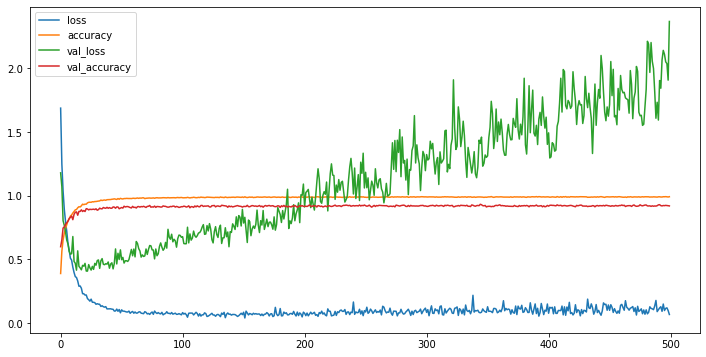

In [40]:
plotHistory(model_final_history)

In [ ]:
test_loss, test_acc  = model_4.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("\nThe Best test Accuracy is :",test_acc*100)

# Librosa

In [41]:
y, sr = librosa.load(librosa.ex('nutcracker'))

In [167]:
features = []

In [168]:
# Chroma
chroma_stft = librosa.feature.chroma_stft(y,sr)
chroma_stft_mean, chroma_stft_var = np.mean(chroma_stft), np.var(chroma_stft)
features += [chroma_stft_mean, chroma_stft_var]

In [169]:
# RMS
rms = librosa.feature.rms(y)
rms_mean, rms_var = np.mean(rms), np.var(rms)
features += [rms_mean, rms_var]

In [170]:
# Spectral Centroid
spectral_centroid = librosa.feature.spectral_centroid(y, sr)
spectral_centroid_mean, spectral_centroid_var = np.mean(spectral_centroid), np.var(spectral_centroid)
features += [spectral_centroid_mean, spectral_centroid_var]

In [171]:
#Spectral Bandwith
spectral_bandwith = librosa.feature.spectral_bandwidth(y, sr)
spectral_bandwith_mean, spectral_bandwith_var = np.mean(spectral_bandwith), np.var(spectral_bandwith)
features += [spectral_bandwith_mean, spectral_bandwith_var]

In [172]:
# Rolloff
rolloff = librosa.feature.spectral_rolloff(y, sr)
rolloff_mean, rolloff_var = np.mean(rolloff), np.var(rolloff)
features += [rolloff_mean, rolloff_var]

In [173]:
# Zero crossing rate
zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
zero_crossing_rate_mean, zero_crossing_rate_var = np.mean(zero_crossing_rate), np.var(zero_crossing_rate)
features += [zero_crossing_rate_mean, zero_crossing_rate_var]

In [174]:
# Harmony and perceptrual
harmony, percussive = librosa.effects.hpss(y)
harmony_mean, harmony_var = np.mean(harmony), np.var(harmony)
percussive_mean, percussive_var = np.mean(percussive), np.var(percussive)
features += [harmony_mean, harmony_var, percussive_mean, percussive_var]

In [175]:
# Tempo 
onset_env = librosa.onset.onset_strength(y, sr)
tempo = librosa.beat.tempo(onset_env, sr)[0]
features += [tempo]

In [176]:
# MFCC
mfcc = librosa.feature.mfcc(y, sr)
mfcc_means, mfcc_var = np.mean(mfcc, axis=1), np.var(mfcc, axis=1)
for index in range(mfcc.shape[0]):
  features += [mfcc_means[index], mfcc_var[index]]

In [177]:
features = np.array([features])
features.shape

(1, 57)

In [181]:
print(int_to_label[np.argmax(model_4.predict(features))])

rock
